## Abstract

**An important part of this challenge is to assess and explain the model to a fictional client with limited statistical knowledge. So your evaluation should include some plots on how your model makes the predictions. Finally you need to give an essesment if it will make sense for the client to implement this model!**

### Challenge
To put things into the right perspective consider the following fictional scenario:

You are a AI Consultant at Data Revenue. One of our clients is a big online wine seller. After a successful strategic consulting we advice the client to optimize his portfolio by creating a rating predictor (predict points given to a wine) for his inventory. We receive a sample dataset (10k rows) from the client and will come back in a week to evaluate our model on a bigger data set that is only accessible from on-premise servers (>100k rows).

The task is to show that a good prediction is possible and thereby make it less risky to implement a full production solution. Our mini pipeline should later be able to run on their on premise machine which has only docker and docker-compose installed.

## Linear Regression

In [13]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import norm


sns.set()

In [14]:
PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

data = pd.read_csv(PATH + '/data_root/raw/wine_dataset.csv')
data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils


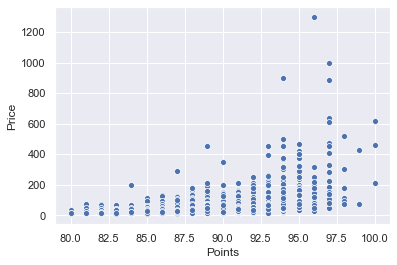

In [15]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=data, x="points", y="price")
plt.xlabel("Points")
plt.ylabel("Price")
plt.show()

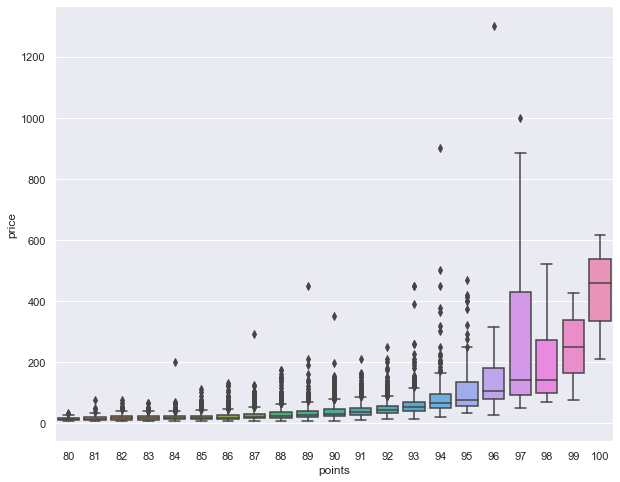

In [16]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="points", y="price", data=data)
plt.show()

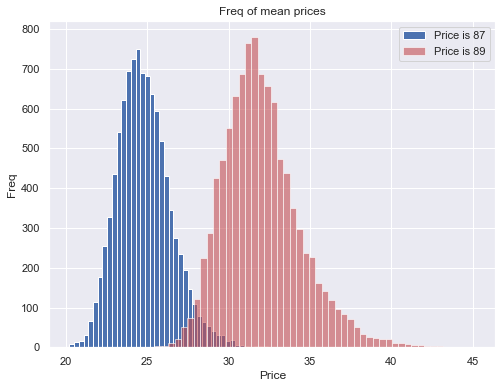

In [17]:
price_1 = data[(data['points'] == 87)&(~data['price'].isnull())]['price'].values
price_2 = data[(data['points'] == 89)&(~data['price'].isnull())]['price'].values

clt1 = []
clt2 = []

for i in range(10000):
    clt1.append(np.mean(np.random.choice(price_1, size=100)))
    clt2.append(np.mean(np.random.choice(price_2, size=100)))
    
plt.figure(figsize=(8, 6))
plt.hist(clt1, bins=50)
plt.hist(clt2, color='r', bins=50, alpha=0.6)
plt.xlabel("Price")
plt.ylabel("Freq")
plt.title(f"Freq of mean prices")
plt.legend(['Price is 87', 'Price is 89'])
plt.show()

In [18]:
pos = np.array(sorted(clt1))[np.array(sorted(clt1)) >= 27.5].shape[0]
norm.pdf(sorted(clt1), loc=np.mean(clt1), scale=np.std(clt1))[10000 - pos]

0.06407675481056398

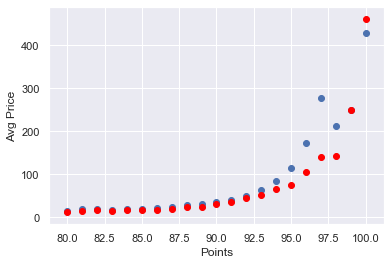

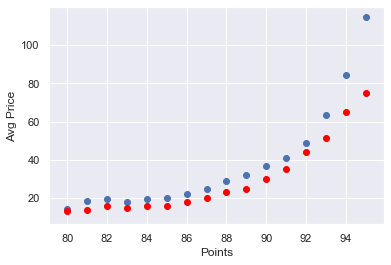

In [19]:
avg_price = data.groupby('points')['price'].mean().values
median_price = data.groupby('points')['price'].median().values
idx = data.groupby('points')['price'].mean().index.values

plt.figure(figsize=(6, 4))
plt.scatter(idx, avg_price)
plt.scatter(idx, median_price, c='red')
plt.xlabel("Points")
plt.ylabel("Avg Price")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(idx[:-5], avg_price[:-5])
plt.scatter(idx[:-5], median_price[:-5], c='red')
plt.xlabel("Points")
plt.ylabel("Avg Price")
plt.show()

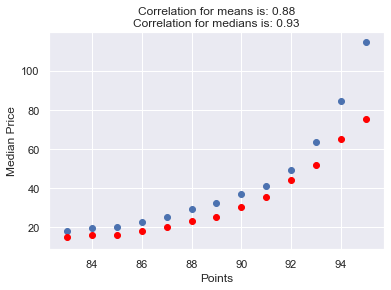

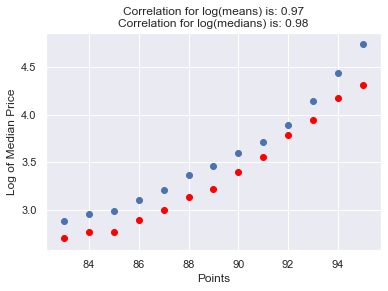

In [20]:
plt.figure(figsize=(6, 4))
plt.scatter(idx[3:-5], avg_price[3:-5])
plt.scatter(idx[3:-5], median_price[3:-5], c='red')
plt.xlabel("Points")
plt.ylabel("Median Price")
plt.title(f"Correlation for means is: {np.round(pd.Series(idx[3:-5]).corr(pd.Series(avg_price[3:-5])), 2)}\n\
Correlation for medians is: {np.round(pd.Series(idx[3:-5]).corr(pd.Series(median_price[3:-5])), 2)}")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(idx[3:-5], np.log(avg_price[3:-5]))
plt.scatter(idx[3:-5], np.log(median_price[3:-5]), c='red')
plt.xlabel("Points")
plt.ylabel("Log of Median Price")
plt.title(f"Correlation for log(means) is: {np.round(pd.Series(idx[3:-5]).corr(pd.Series(np.log(avg_price[3:-5]))), 2)}\n\
Correlation for log(medians) is: {np.round(pd.Series(idx[3:-5]).corr(pd.Series(np.log(median_price[3:-5]))), 2)}")
plt.show()

In [21]:
no_nans = data.copy()
no_nans.loc[no_nans['price'].isnull(), 'price'] = no_nans['price'].mean()
no_nans['price'] = np.log(no_nans['price'])

test_size = 0.3
split_value = int(np.round(data.shape[0] * test_size, 0))

X_train = no_nans['price'][:-split_value].values.reshape(-1, 1)
X_test = no_nans['price'][-split_value:].values.reshape(-1, 1)
y_train = no_nans['points'][:-split_value].values.reshape(-1, 1)
y_test = no_nans['points'][-split_value:].values.reshape(-1, 1)

r = linear_model.LinearRegression()

r.fit(X_train, y_train)
y_pred = r.predict(X_test)

In [22]:
print('Coefficient is:', list(*r.coef_)[0], '\nIntercept is:', list(r.intercept_)[0], end='\n\n')
print(f'MSE: {mean_squared_error(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')

Coefficient is: 2.8009709420029396 
Intercept is: 79.1484482153131

MSE: 6.00
MAE: 1.96


In [23]:
print(f"Naive approach (linear model from logarithm of the price) is not only good,\n\
but robust on whole dataset as well:\n\
MSE on whole dataset: {mean_squared_error(no_nans['points'], 79.15 + no_nans['price'] * 2.8):.2f} \n\
MAE on whole dataset: {mean_absolute_error(no_nans['points'], 79.15 + no_nans['price'] * 2.8):.2f}")

Naive approach (linear model from logarithm of the price) is not only good,
but robust on whole dataset as well:
MSE on whole dataset: 6.01 
MAE on whole dataset: 1.96


No need for ML as `np.log(price)` nicely approximates target variable. The more data we have, the more accurate and robust such estimator will be. Having only 10k dataset, we might say that target values [80:83]$\cup$[96:] serve as an outliers. (Low quantity of observations, high variance). Having more observations, probably, will fix it.

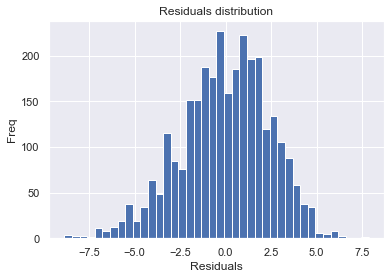

In [24]:
residuals_lr = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals_lr, bins=40)
plt.xlabel("Residuals")
plt.ylabel("Freq")
plt.title(f"Residuals distribution")
plt.show()

## Dask LR

Main idea is to replicate experiments using Dask Framework.

In [171]:
import dask as dd

from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.metrics import mean_squared_error, mean_absolute_error

In [172]:
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='2GB')
client

Client Scheduler: inproc://192.168.0.11/18456/1 Dashboard: http://192.168.0.11:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [195]:
PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
coltouse = ['country', 'points', 'price', 'taster_name']

d = dd.dataframe.read_csv(PATH + '/data_root/raw/wine_dataset.csv', usecols=coltouse, blocksize=1024*100)
d.head(2)

,country,points,price,taster_name
0,Italy,90,30.0,Kerin O’Keefe
1,France,87,22.0,Roger Voss


In [196]:
d['price'] = d['price'].fillna(d['price'].mean())
d['price'] = np.log(d['price'])

train, test = train_test_split(d, test_size = 0.3, shuffle=False)

X_train = train['price'].to_dask_array(lengths=True).reshape(-1, 1)
y_train = train['points'].to_dask_array(lengths=True).reshape(-1, 1)
X_test = test['price'].to_dask_array(lengths=True).reshape(-1, 1)
y_test = test['points'].to_dask_array(lengths=True).reshape(-1, 1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test).reshape(-1, 1)

In [197]:
print('Coefficient is:', lr.coef_[0], '\nIntercept is:', lr.intercept_, end='\n\n')
print(f'MSE: {mean_squared_error(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')

Coefficient is: 2.796577777199405 
Intercept is: 79.14781449945022

MSE: 5.94
MAE: 1.94


Seems legit. Coefficients and scores from Dask implementation are almost the same with the ones from Sklearn. (Subject to vary a bit from partition to partition).

## Lightgbm

In [25]:
import os
import re
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


sns.set()

In [26]:
PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

data = pd.read_csv(PATH + '/data_root/raw/wine_dataset.csv')
data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils


In [27]:
coltocat = ['country', 'province', 'taster_name', 'region_1', 'region_2', 'variety']

for col in coltocat:
    data[col] = data[col].astype("category")
    
year = []

for i in range(data.shape[0]):
    if len(re.findall(r'.*([1-3][0-9]{3})', data['title'][i])) == 0:
        year.append(np.nan)
    else:
        year.append(int(re.findall(r'.*([1-3][0-9]{3})', data['title'][i])[0]))

data['year'] = year
data.loc[(data['year'] < 1900)&(data['year'] > 2021), 'year'] = np.nan

coltouse = ['country', 'price', 'province', 'taster_name', 'region_1', 'region_2', 'variety', 'year']
cat_features = ['country', 'province', 'taster_name', 'region_1', 'region_2', 'variety']

In [28]:
X_temp, X_test, y_temp, y_test = train_test_split(data[coltouse],
                                                  data[['points']], 
                                                  stratify=data['points'],
                                                  test_size=0.3, 
                                                  random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp,
                                                  y_temp,
                                                  test_size=0.2, 
                                                  random_state=42)

In [29]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.04,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_data = lgb.Dataset(X_train, 
                         y_train, 
                         categorical_feature=cat_features, 
                         free_raw_data=False)

valid_data = lgb.Dataset(X_val, 
                         y_val, 
                         categorical_feature=cat_features, 
                         free_raw_data=False)

In [30]:
gbm = lgb.train(params, 
                train_data, 
                valid_sets=[valid_data], 
                verbose_eval=False, 
                categorical_feature=cat_features, 
                num_boost_round=1200,
                early_stopping_rounds=100)

y_pred = gbm.predict(X_test)

In [31]:
print(f'MSE: {mean_squared_error(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')

MSE: 5.01
MAE: 1.77


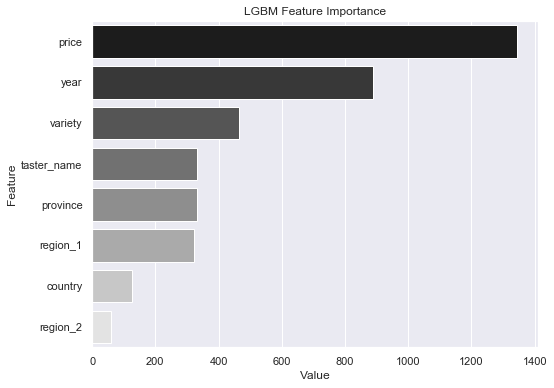

In [32]:
feature_imp = pd.DataFrame({'Value':gbm.feature_importance(),'Feature':X_train.columns})

plt.figure(figsize=(8, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False), palette="gray")
plt.title('LGBM Feature Importance')
plt.show()

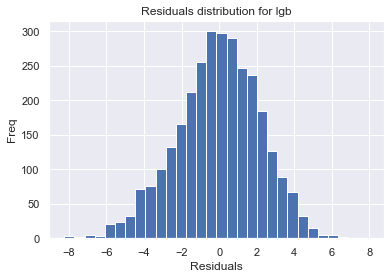

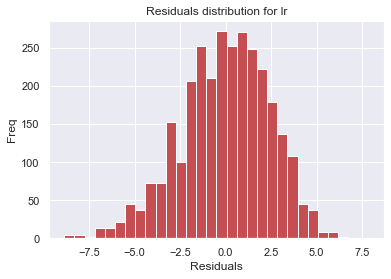

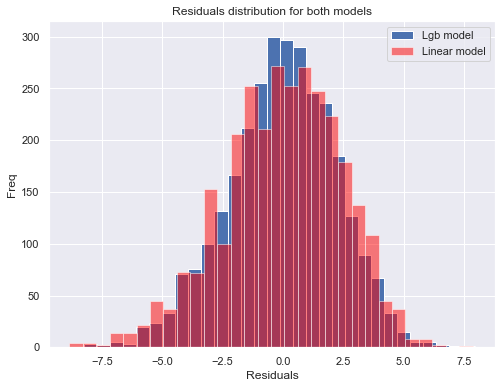

In [39]:
residuals_lgb = y_test.values - y_pred.reshape(-1, 1)

plt.figure(figsize=(6, 4))
plt.hist(residuals_lgb, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Freq")
plt.title(f"Residuals distribution for lgb")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(residuals_lr, bins=30, color='r')
plt.xlabel("Residuals")
plt.ylabel("Freq")
plt.title(f"Residuals distribution for lr")
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(residuals_lgb, bins=30)
plt.hist(residuals_lr, bins=30, color='red', alpha=0.5)
plt.xlabel("Residuals")
plt.ylabel("Freq")
plt.title(f"Residuals distribution for both models")
plt.legend(['Lgb model', 'Linear model'])
# plt.savefig('temp.png')
plt.show()

In [3]:
scores = {'score':[1.96, 6.00, 1.82, 5.13], 
          'metrics':['MAE', 'MSE', 'MAE', 'MSE'], 
          'model':['Linear', 'Linear', 'Lightgbm', 'Lightgbm']}

s = pd.DataFrame(scores)
s.head()

,score,metrics,model
0,1.96,MAE,Linear
1,6.00,MSE,Linear
2,1.82,MAE,Lightgbm
3,5.13,MSE,Lightgbm


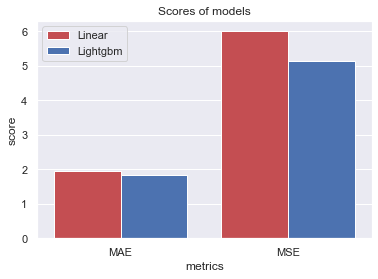

In [4]:
plt.figure(figsize=(6, 4))
sns.barplot(x="metrics", y="score", hue="model", data=s, palette=['r', 'b'], saturation=1)
plt.title('Scores of models')
plt.legend(loc=2)
plt.savefig('temp.png', dpi=250)
plt.show()